In [144]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [145]:
SEED = 462
np.random.seed(SEED)

In [146]:
data_path = os.path.join("data", "tabular")

In [147]:
class Dataset:
    def __init__(self, train_path, val_path, test_path):
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.mean = None
        self.std = None
        self.label_map = None

    def load_csv(self, path):
        df = pl.read_csv(path)
        data = df.to_numpy()
        X = data[:, :-1].astype(float)
        Y_str = data[:, -1]
        return X, Y_str

    def normalize(self, X, fit=False):
        if fit:
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0)
            self.std[self.std == 0] = 1.0

        return (X - self.mean) / self.std

    def get_data(self):
        X_train, Y_train = self.load_csv(self.train_path)
        X_val, Y_val = self.load_csv(self.val_path)
        X_test, Y_test = self.load_csv(self.test_path)

        X_train = self.normalize(X_train, fit=True)
        X_val = self.normalize(X_val, fit=False)
        X_test = self.normalize(X_test, fit=False)

        return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)

In [148]:
class LogisticRegression:
    def __init__(self, learning_rate, num_iters):
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.weights = None
        self.bias = None
        self.cls = None

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)

    def logistic_loss(self, y_true, y_pred):
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def train(self, X, Y):
        n_examples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.num_iters):
            y_pred = self.predict_proba(X)
            y_diff = y_pred - Y

            self.weights -= self.learning_rate * np.dot(X.T, y_diff) / n_examples
            self.bias -= self.learning_rate * np.mean(y_diff)

In [149]:
class LogisticRegressionOVA:
    def __init__(self, learning_rate=0.01, num_iters=1000):
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        self.models = []
        self.classes = None
        self.history = None

    def train(self, X_train, Y_train, X_val, Y_val):
        self.classes = np.unique(Y_train)
        self.models = []
        self.history = {}

        for cls in self.classes:
            print(f"--- Training for class {cls} ---")
            Y_train_bin = (Y_train == cls).astype(float)
            Y_val_bin = (Y_val == cls).astype(float)

            model = LogisticRegression(self.learning_rate, self.num_iters)
            # Custom training loop to print loss
            n_examples, n_features = X_train.shape
            model.weights = np.zeros(n_features)
            model.bias = 0
            model.cls = cls

            train_losses = []
            val_losses = []

            for i in range(model.num_iters):
                y_pred = model.predict_proba(X_train)
                y_diff = y_pred - Y_train_bin

                model.weights -= model.learning_rate * np.dot(X_train.T, y_diff) / n_examples
                model.bias -= model.learning_rate * np.mean(y_diff)

                train_loss = model.logistic_loss(Y_train_bin, y_pred)
                val_pred = model.predict_proba(X_val)
                val_loss = model.logistic_loss(Y_val_bin, val_pred)

                train_losses.append(train_loss)
                val_losses.append(val_loss)

                if i % 100 == 0:
                    print(f"Iter {i}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

            self.models.append(model)
            self.history[cls] = {"train": train_losses, "val": val_losses}

    def predict(self, X):
        probs = self.predict_proba_matrix(X)
        return [self.models[idx].cls for idx in np.argmax(probs, axis=1)]

    def predict_proba_matrix(self, X):
        return np.column_stack([model.predict_proba(X) for model in self.models])

In [150]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100


def precision(y_true, y_pred):
    classes = np.unique(y_true)
    ps = [np.sum((y_pred == c) & (y_true == c)) / np.sum(y_pred == c) if np.sum(y_pred == c) > 0 else 0 for c in classes]
    return np.mean(ps)


def recall(y_true, y_pred):
    classes = np.unique(y_true)
    rs = [np.sum((y_pred == c) & (y_true == c)) / np.sum(y_true == c) if np.sum(y_true == c) > 0 else 0 for c in classes]
    return np.mean(rs)


def f1_score(y_true, y_pred):
    classes = np.unique(y_true)
    f1s = []
    for c in classes:
        tp = np.sum((y_pred == c) & (y_true == c))
        p = tp / np.sum(y_pred == c) if np.sum(y_pred == c) > 0 else 0
        r = tp / np.sum(y_true == c) if np.sum(y_true == c) > 0 else 0
        f1s.append(2 * p * r / (p + r) if (p + r) > 0 else 0)
    return np.mean(f1s)


def auc(y_true_bin, y_score):
    desc = np.argsort(y_score)[::-1]
    y_true_sorted = y_true_bin[desc]
    tpr = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    fpr = np.cumsum(1 - y_true_sorted) / np.sum(1 - y_true_sorted)
    return np.trapezoid(tpr, fpr)

In [151]:
dataset = Dataset(
    train_path=os.path.join(data_path, "train_processed.csv"),
    val_path=os.path.join(data_path, "validation_processed.csv"),
    test_path=os.path.join(data_path, "test_processed.csv"),
)

(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dataset.get_data()

model = LogisticRegressionOVA(learning_rate=0.1, num_iters=1000)

print("Starting Training...")
start_time = time.time()
model.train(X_train, Y_train, X_val, Y_val)
end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal Training Time: {training_time:.4f} seconds")

Starting Training...
--- Training for class banana ---
Iter 0: Train Loss 0.6931, Val Loss 0.6769
Iter 100: Train Loss 0.3433, Val Loss 0.3289
Iter 200: Train Loss 0.3216, Val Loss 0.3022
Iter 300: Train Loss 0.3170, Val Loss 0.2949
Iter 400: Train Loss 0.3156, Val Loss 0.2920
Iter 500: Train Loss 0.3151, Val Loss 0.2906
Iter 600: Train Loss 0.3150, Val Loss 0.2899
Iter 700: Train Loss 0.3149, Val Loss 0.2895
Iter 800: Train Loss 0.3149, Val Loss 0.2892
Iter 900: Train Loss 0.3149, Val Loss 0.2891
--- Training for class carrot ---
Iter 0: Train Loss 0.6931, Val Loss 0.6808
Iter 100: Train Loss 0.3670, Val Loss 0.3694
Iter 200: Train Loss 0.3295, Val Loss 0.3353
Iter 300: Train Loss 0.3168, Val Loss 0.3246
Iter 400: Train Loss 0.3110, Val Loss 0.3201
Iter 500: Train Loss 0.3081, Val Loss 0.3180
Iter 600: Train Loss 0.3064, Val Loss 0.3169
Iter 700: Train Loss 0.3054, Val Loss 0.3164
Iter 800: Train Loss 0.3048, Val Loss 0.3162
Iter 900: Train Loss 0.3044, Val Loss 0.3161
--- Training fo

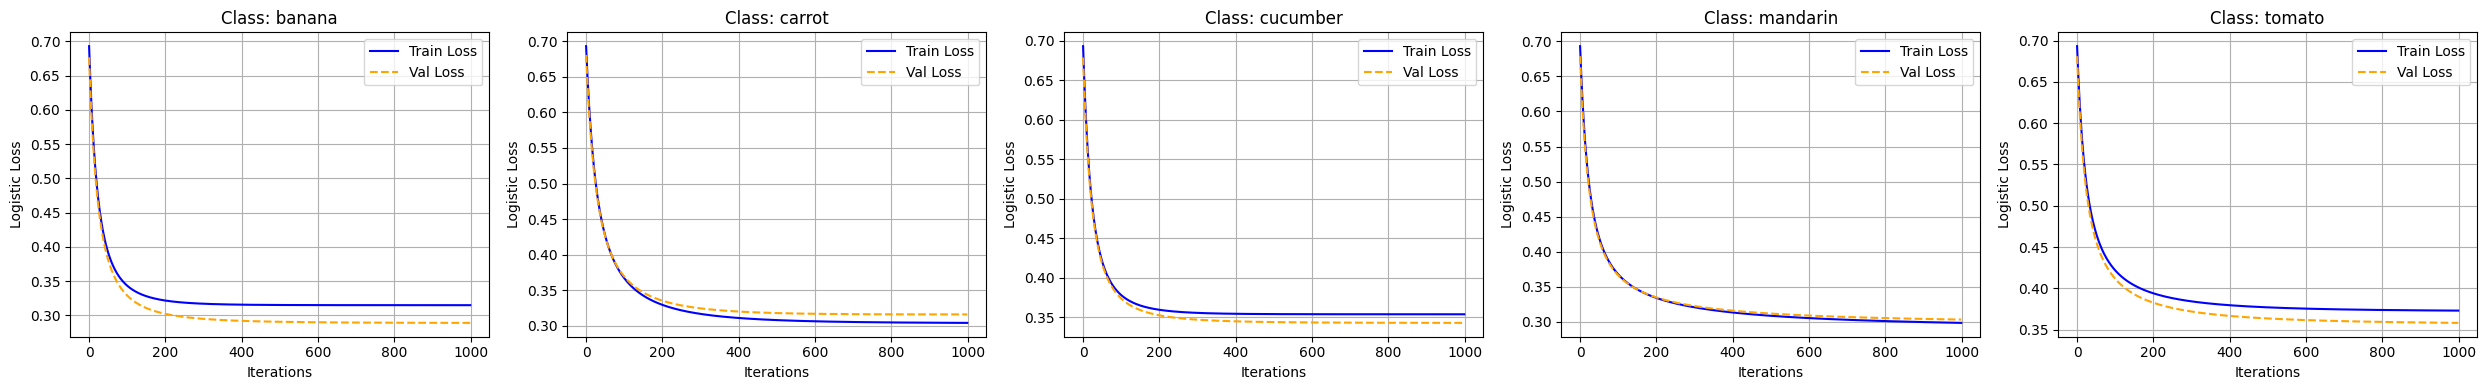

In [152]:
classes = model.classes
n_classes = len(classes)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes * 5, 4))

for i, cls in enumerate(classes):
    hist = model.history[cls]
    steps = range(model.num_iters)

    axes[i].plot(steps, hist["train"], label="Train Loss", color="blue")
    axes[i].plot(steps, hist["val"], label="Val Loss", color="orange", linestyle="--")

    axes[i].set_title(f"Class: {cls}")
    axes[i].set_xlabel("Iterations")
    axes[i].set_ylabel("Logistic Loss")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [153]:
train_pred = np.array(model.predict(X_train))
train_probs = model.predict_proba_matrix(X_train)

print("----- Training Metrics -----")
print(f"Accuracy: {accuracy(Y_train, train_pred):.2f}%")
print(f"Precision: {precision(Y_train, train_pred):.4f}")
print(f"Recall: {recall(Y_train, train_pred):.4f}")
print(f"F1 Score: {f1_score(Y_train, train_pred):.4f}")

for i, cls in enumerate(model.classes):
    y_train_bin = (Y_train == cls).astype(int)
    auc_val = auc(y_train_bin, train_probs[:, i])
    print(f"AUC for {cls}: {auc_val:.4f}")

----- Training Metrics -----
Accuracy: 60.01%
Precision: 0.5245
Recall: 0.5585
F1 Score: 0.5054
AUC for banana: 0.9087
AUC for carrot: 0.9289
AUC for cucumber: 0.8391
AUC for mandarin: 0.8919
AUC for tomato: 0.8442


In [154]:
val_pred = np.array(model.predict(X_val))
val_probs = model.predict_proba_matrix(X_val)

print("----- Validation Metrics -----")
print(f"Accuracy: {accuracy(Y_val, val_pred):.2f}%")
print(f"Precision: {precision(Y_val, val_pred):.4f}")
print(f"Recall: {recall(Y_val, val_pred):.4f}")
print(f"F1 Score: {f1_score(Y_val, val_pred):.4f}")

for i, cls in enumerate(model.classes):
    y_val_bin = (Y_val == cls).astype(int)
    auc_val = auc(y_val_bin, val_probs[:, i])
    print(f"AUC for {cls}: {auc_val:.4f}")

----- Validation Metrics -----
Accuracy: 62.40%
Precision: 0.5865
Recall: 0.5831
F1 Score: 0.5293
AUC for banana: 0.9203
AUC for carrot: 0.9212
AUC for cucumber: 0.8452
AUC for mandarin: 0.8825
AUC for tomato: 0.8593


In [155]:
test_pred = np.array(model.predict(X_test))
test_probs = model.predict_proba_matrix(X_test)

print("----- Test Metrics -----")
print(f"Accuracy: {accuracy(Y_test, test_pred):.2f}%")
print(f"Precision: {precision(Y_test, test_pred):.4f}")
print(f"Recall: {recall(Y_test, test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, test_pred):.4f}")

for i, cls in enumerate(model.classes):
    y_test_bin = (Y_test == cls).astype(int)
    auc_val = auc(y_test_bin, test_probs[:, i])
    print(f"AUC for {cls}: {auc_val:.4f}")

----- Test Metrics -----
Accuracy: 60.80%
Precision: 0.6614
Recall: 0.5858
F1 Score: 0.5161
AUC for banana: 0.9060
AUC for carrot: 0.9249
AUC for cucumber: 0.7768
AUC for mandarin: 0.9492
AUC for tomato: 0.8556


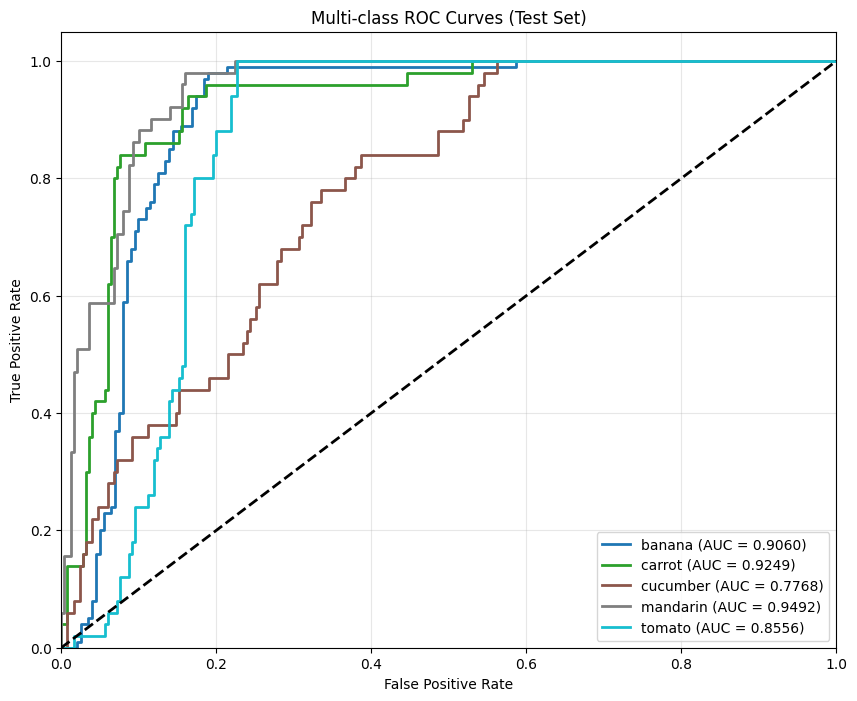

In [156]:
colors = plt.get_cmap("tab10", len(model.classes))
plt.figure(figsize=(10, 8))

for i, cls in enumerate(model.classes):
    y_test_bin = (Y_test == cls).astype(int)
    y_score = test_probs[:, i]

    desc = np.argsort(y_score)[::-1]
    y_true_sorted = y_test_bin[desc]

    tpr = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    fpr = np.cumsum(1 - y_true_sorted) / np.sum(1 - y_true_sorted)

    tpr = np.insert(tpr, 0, 0)
    fpr = np.insert(fpr, 0, 0)

    auc_score = np.trapezoid(tpr, fpr)
    plt.plot(fpr, tpr, color=colors(i), lw=2, label=f"{cls} (AUC = {auc_score:.4f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves (Test Set)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()